## 이미지 증강 데이터를 학습데이터로 변경 후  기존 학습데이터는 테스트 데이터로 변경 후 학습

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
#print the pytorch version
# device = torch.cuda.is_available()
device ="cuda" if torch.cuda.is_available() else "cpu"
device, torch.__version__

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
print(train_on_gpu)

CUDA is available!  Training on GPU ...
True


In [3]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/test'

In [4]:
test_dir = data_dir + '/valid'

In [5]:
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

In [6]:
len(train_data), len(valid_data),len(train_loader),len(valid_loader), len(test_data), len(test_loader)

(48500, 1500, 3032, 94, 250, 16)

In [7]:
import json
class_names = train_data.classes
with open('./dataset/config.json', 'r', encoding='UTF8') as f:
    cat_to_name = json.load(f)

In [8]:
inputs, classes = next(iter(test_loader))
print(train_data.class_to_idx)
print(classes)

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


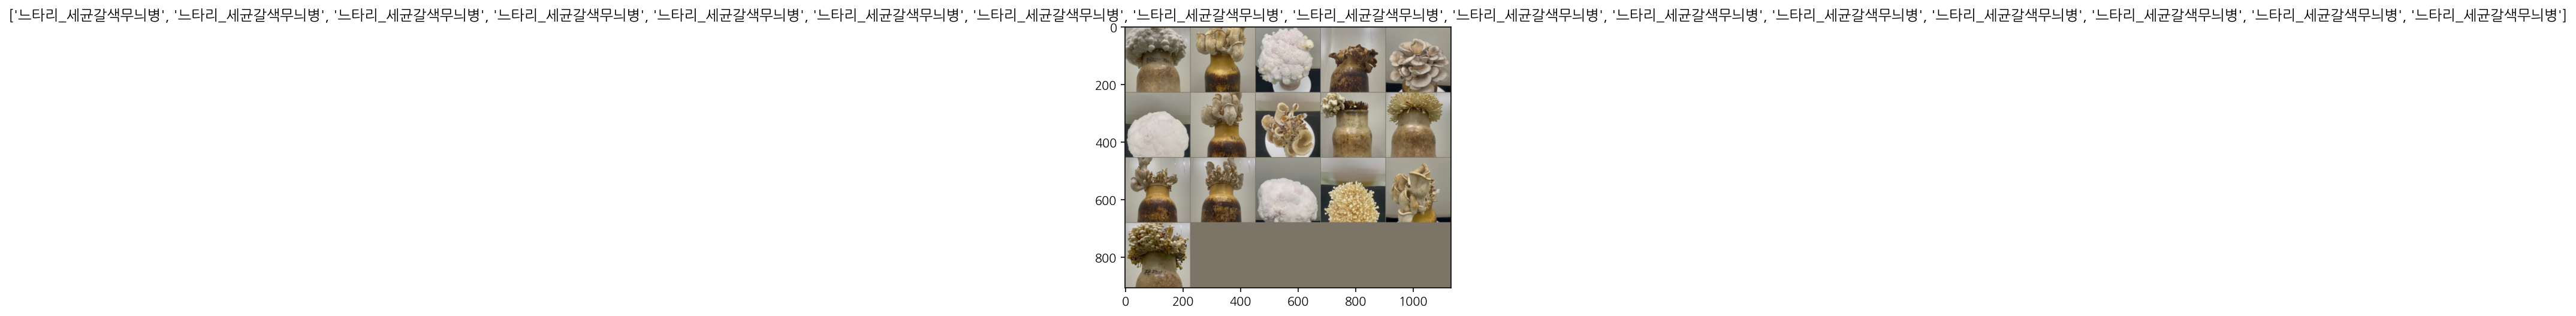

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    inp = inp.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=5)

imshow(out,title=[cat_to_name[str(x.item())] for x in classes])

In [10]:
# TODO: Build and train your network

model = models.resnet34(pretrained=True)
# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

In [11]:
#define untrained feed-forward network as a classifier
num_inp = model.fc.in_features
model.fc = nn.Linear(num_inp, 5)
if train_on_gpu:
    model.cuda()

In [12]:
criterion = torch.nn.CrossEntropyLoss()
#only train the classifier part, the features part are frozen
optimizer = optim.SGD(model.fc.parameters(), lr=0.015, momentum=0.9)

In [13]:
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [14]:
#TO UNFREEZE THE WEIGHTS FOR THE SECOND TIME TRAINING AND DON'T FORGET TO CHANGE THE OPTIMIZER TOO!
for param in model.parameters():
    param.requires_grad = True
    
# train the WHOLE part instead of just the classifier!, THIS IS THE SECOND ITERATION OF THE TRAINING AND REDUCE THE LEARNING RATE TOO!
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)

In [15]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
n_epochs = 11 # you may increase this number to train a final model
valid_loss_min = np.Inf # track change in validation loss

#Keep track for the plt chart
train_losses, test_losses = [], []

In [16]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
n_epochs = 11 # you may increase this number to train a final model
valid_loss_min = np.Inf # track change in validation loss

#Keep track for the plt chart
train_losses, test_losses = [], []

for epoch in range(1, n_epochs):
    #keep track on the learning rate and update the learning rate with specific gamma based on the step size of epoch, learning rate annealing
    scheduler.step()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    running_corrects = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        # this loop will iterate 410x (total train images = 6552 / 16 batch size)
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        #set gradien calculation on during training phase
        torch.set_grad_enabled(True)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        #print('train_loss_acc:',train_loss,tracktrainnum)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #set gradien calculation off during validation phase
        torch.set_grad_enabled(False)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #calculate preds for accuracy metrics
        _, preds = torch.max(output, 1)
        
        # update average validation loss 
        valid_loss += loss.item()
        #update running validation accuracy
        running_corrects += torch.sum(preds == target.data)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    epoch_acc = running_corrects.double() /len(valid_loader.dataset)
    
    #to track the train loss and put all the values in a list to be displayed
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {}-{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}'.format(
        epoch, n_epochs, train_loss, valid_loss, epoch_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        
print('STARTING THE SECOND ITERATION WITH UNFREEZING THE WHOLE LAYER AND STARTING WITH A SMALLER LEARNING RATE')
#DOING THE SECOND ITERATION WITH UNFREEZING THE WHOLE LAYER INSTEAD OF JUST THE FC(CLASSIFIER) LAYER AND START AT A SMALLER LEARNING RATE 
#TO UNFREEZE THE WEIGHTS FOR THE SECOND TIME TRAINING AND DON'T FORGET TO CHANGE THE OPTIMIZER TOO!
for param in model.parameters():
    param.requires_grad = True
    
# train the WHOLE part instead of just the classifier!, THIS IS THE SECOND ITERATION OF THE TRAINING AND REDUCE THE LEARNING RATE TOO!
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)

n_epochs = 11 # you may increase this number to train a final model

for epoch in range(1, n_epochs):
    #keep track on the learning rate and update the learning rate with specific gamma based on the step size of epoch, learning rate annealing
    scheduler.step()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    running_corrects = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        # this loop will iterate 410x (total train images = 6552 / 16 batch size)
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        #set gradien calculation on during training phase
        torch.set_grad_enabled(True)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        #print('train_loss_acc:',train_loss,tracktrainnum)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #set gradien calculation off during validation phase
        torch.set_grad_enabled(False)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #calculate preds for accuracy metrics
        _, preds = torch.max(output, 1)
        
        # update average validation loss 
        valid_loss += loss.item()
        #update running validation accuracy
        running_corrects += torch.sum(preds == target.data)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    epoch_acc = running_corrects.double() /len(valid_loader.dataset)
    
    #to track the train loss and put all the values in a list to be displayed
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {}-{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}'.format(
        epoch, n_epochs, train_loss, valid_loss, epoch_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_cifar_resnet152.pt')
        valid_loss_min = valid_loss

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1-11 	Training Loss: 0.027565 	Validation Loss: 0.002339	Validation Accuracy: 0.992667
Validation loss decreased (inf --> 0.002339).  Saving model ...
Epoch: 2-11 	Training Loss: 0.013952 	Validation Loss: 0.000728	Validation Accuracy: 0.998000
Validation loss decreased (0.002339 --> 0.000728).  Saving model ...
Epoch: 3-11 	Training Loss: 0.011101 	Validation Loss: 0.000460	Validation Accuracy: 0.997333
Validation loss decreased (0.000728 --> 0.000460).  Saving model ...
Epoch: 4-11 	Training Loss: 0.009332 	Validation Loss: 0.000317	Validation Accuracy: 0.998000
Validation loss decreased (0.000460 --> 0.000317).  Saving model ...
Epoch: 5-11 	Training Loss: 0.008333 	Validation Loss: 0.000094	Validation Accuracy: 0.999333
Validation loss decreased (0.000317 --> 0.000094).  Saving model ...
Epoch: 6-11 	Training Loss: 0.007306 	Validation Loss: 0.000088	Validation Accuracy: 1.000000
Validation loss decreased (0.000094 --> 0.000088).  Saving model ...
Epoch: 7-11 	Training Loss:

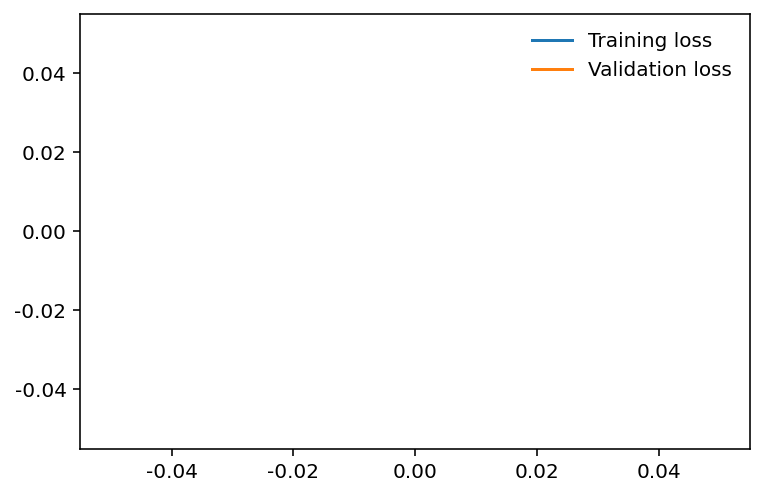

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)